<a href="https://colab.research.google.com/github/edogriba/NAML-2024/blob/main/LAB06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 06

## Feed-Forward Artificial Neural Networks

### Learning the XOR function

Let us consider the XOR ("exclusive or") function. The [truth table](https://en.wikipedia.org/wiki/Exclusive_or#Truth_table) of the XOR function is:

In [47]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import time

In [48]:
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
print(inputs)

outputs = np.array([[0], [1], [1], [0]])


[[0 0]
 [0 1]
 [1 0]
 [1 1]]


We consider a fully connected ANN with the following architechture and with $\tanh(\cdot)$ as activation function:

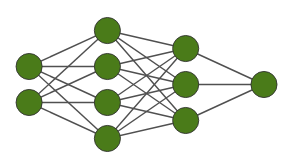

The input of the network are the truth values of the two inputs (0 = False, 1 = True). The output is the **likelihood** (the "probability") of the truth value of the result. Hence, we want the output to be in $[0, 1]$. For this reason, we apply the activation function also to the last layer, and we rescale the output between 0 and 1.


The architecture is defined by the following **hyperparameters**:

In [49]:
n1, n2, n3, n4 = 2, 4, 3, 1

Define the parameters (weights and biases) of the ANN.
Initialize the weights sampling from a standard normal distribution, and initialize to zero the biases.

Define both the weights and the biases as a 2-dimensional `jax` array (you can define them in `numpy` and then convert them).

In [50]:
np.random.seed(0)

W1 = np.random.randn(n2, n1)
b1 = np.zeros((4, 1))

W2 = np.random.randn(n3, n2)
b2 = np.zeros((3, 1))

W3 = np.random.randn(n4, n3)
b3 = np.zeros((1, 1))

params = [W1, b1, W2, b2, W3, b3]
params = [jnp.array(p) for p in params]

Define a function that implements the ANN:
```python
def ANN(x, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `params`: list of the parameters
and with output
- `y`: num_samples by 1 `numpy` array

Then, test the function on `inputs` and `params`.

In [51]:
def ANN(x, params):
  W1, b1, W2, b2, W3, b3 = params
  layer1 = x.T
  layer2 = jnp.tanh(W1 @ layer1 + b1)
  layer3 = jnp.tanh(W2 @ layer2 + b2)
  layer4 = jnp.tanh(W3 @ layer3 + b3)
  # Rescale the output between [0, 1]
  layer4 = (layer4 + 1.0) / 2.0
  return layer4.T

In [52]:
for input in inputs:
  out = ANN(input.reshape((-1, 2)), params)
  print(f"{input[0]} XOR {input[1]} --> {out}")


0 XOR 0 --> [[0.5]]
0 XOR 1 --> [[0.5722416]]
1 XOR 0 --> [[0.107804]]
1 XOR 1 --> [[0.10987768]]


Define a function that computes the quadratic loss on a set of data:
```python
def loss_quadratic(x, y, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.

In [53]:
def loss_quadratic(x, y, params):
  y_pred = ANN(x, params)
  error = y_pred - y
  return jnp.sum(error**2)

loss_quadratic(inputs, outputs, params)

Array(1.2410641, dtype=float32)

Define a function that computes the cross-entropy loss on a set of data:

$$-\sum_i y_i \log(y(x_i; \theta)) + (1 - y_i) \log(1- y(x_i; \theta)) $$

```python
def loss_crossentropy(x, y, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.

In [54]:
def loss_cross_entropy(x, y, params):
  y_pred = ANN(x, params)
  return -jnp.sum(y * jnp.log(y_pred) + (1-y) * jnp.log(1 - y_pred))

loss_cross_entropy(inputs, outputs, params)

Array(3.5951784, dtype=float32)

Using the JIT module of JAX, compile both the losses defined above and their gradients w.r.t. the parameters.

In [55]:
loss_quad = jax.jit(loss_quadratic)
grad_quad = jax.jit(jax.grad(loss_quad, argnums=2))

loss_X = jax.jit(loss_cross_entropy)
grad_X = jax.jit(jax.grad(loss_X, argnums=2))


Implement the GD (gradient descent) method, with learning rate 0.1 and train the ANN, using either the quadratic or the cross-entropy loss function.
Collect the training history of both loss functions at each training epoch and plot them.

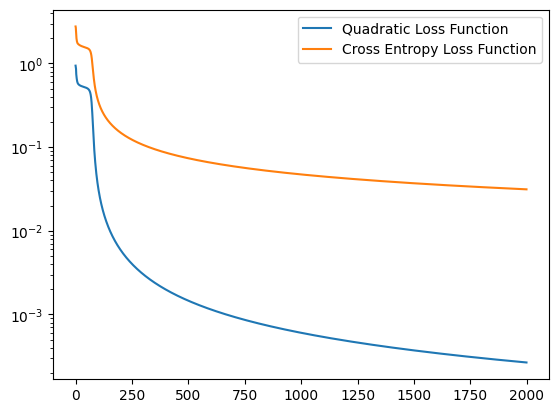

In [56]:
lr = 0.1
n_epochs = 2000

hist_quad_loss = []
hist_X_loss = []

for epoch in range(n_epochs):
  grad_val = grad_quad(inputs, outputs, params)
  for i in range(len(params)):
    params[i] = params[i] - lr * grad_val[i]
  hist_quad_loss.append(loss_quad(inputs, outputs, params))
  hist_X_loss.append(loss_X(inputs, outputs, params))

plt.semilogy(hist_quad_loss, label="Quadratic Loss Function")
plt.semilogy(hist_X_loss, label="Cross Entropy Loss Function")
plt.legend()


Finally, print the truth table associated with the ANN and compute its accuracy.

In [57]:
for input in inputs:
  out = ANN(input.reshape(-1, 2), params)
  print(f"{input[0]} XOR {input[1]}: {out}")

0 XOR 0: [[0.00479445]]
0 XOR 1: [[0.9935236]]
1 XOR 0: [[0.98872]]
1 XOR 1: [[0.00861797]]


In [60]:
TP = ANN(jnp.array([[0, 1], [1, 0]]), params)
TN = 1 - ANN(jnp.array([[0, 0], [1, 1]]), params)
accuracy = (sum(TP)+ sum(TN)) / 4
print(f"Accuracy {accuracy[0]*100:.2f}%")

Accuracy 99.22%
